In [3]:
%load_ext autoreload
%autoreload 2

In [ ]:
# TODO some of this has since been refactored, see jwst.ipynb for cleaner example

In [4]:
import pandas as pd
import json

import matplotlib.pyplot as plt

from gzreduction.vote_sources.panoptes_exports import export_to_responses
from gzreduction.schemas.cd_schema import schema

from gzreduction.vote_sources.panoptes_exports import aggregate

In [5]:
date_str = '2023-01-02'

In [6]:
save_loc = f'/nvme1/scratch/walml/repos/gz-downloads/gz_cosmic_dawn_aggregation_{date_str}.parquet'

In [5]:
# nrows = 10000
nrows = None
clf = pd.read_csv(f'/nvme1/scratch/walml/repos/gz-downloads/cosmic-dawn-workflow-classifications_{date_str}.csv', nrows=nrows)
clf

,classification_id,user_name,user_id,user_ip,workflow_id,workflow_name,workflow_version,created_at,gold_standard,expert,metadata,annotations,subject_data,subject_ids
0,445824444,not-logged-in-87516d176b8109c5790a,NaN,87516d176b8109c5790a,21802,Cosmic Dawn workflow,67.91,2022-10-21 14:17:10 UTC,NaN,NaN,"{""source"":""api"",""session"":""f72d06e322dcf3e5b58...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""81371870"":{""retired"":{""id"":108698450,""workfl...",81371870
1,445824476,not-logged-in-87516d176b8109c5790a,NaN,87516d176b8109c5790a,21802,Cosmic Dawn workflow,67.91,2022-10-21 14:17:21 UTC,NaN,NaN,"{""source"":""api"",""session"":""f72d06e322dcf3e5b58...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""81398125"":{""retired"":{""id"":108658138,""workfl...",81398125
2,445824529,not-logged-in-255135a77efc89aa02ab,NaN,255135a77efc89aa02ab,21802,Cosmic Dawn workflow,67.91,2022-10-21 14:17:38 UTC,NaN,NaN,"{""source"":""api"",""session"":""f72d06e322dcf3e5b58...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""81416697"":{""retired"":null,""!id"":489192,""!ra""...",81416697
3,445824555,not-logged-in-bc67139701091a0674a8,NaN,bc67139701091a0674a8,21802,Cosmic Dawn workflow,67.91,2022-10-21 14:17:49 UTC,NaN,NaN,"{""source"":""api"",""session"":""f72d06e322dcf3e5b58...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""81417291"":{""retired"":null,""!id"":503662,""!ra""...",81417291
4,445824629,not-logged-in-0aebbc990c6864b00ff4,NaN,0aebbc990c6864b00ff4,21802,Cosmic Dawn workflow,67.91,2022-10-21 14:18:20 UTC,NaN,NaN,"{""source"":""api"",""session"":""f72d06e322dcf3e5b58...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""81361994"":{""retired"":{""id"":108691250,""workfl...",81361994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551833,459855595,AniaPearson,2555930.0,a6d3a318e58d1195d129,21802,Cosmic Dawn workflow,70.94,2023-01-03 12:37:49 UTC,NaN,NaN,"{""source"":""api"",""session"":""037e19c66082b091fbb...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""81348950"":{""retired"":null,""!id"":134489,""!ra""...",81348950
551834,459855606,AniaPearson,2555930.0,a6d3a318e58d1195d129,21802,Cosmic Dawn workflow,70.94,2023-01-03 12:37:58 UTC,NaN,NaN,"{""source"":""api"",""session"":""037e19c66082b091fbb...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""81427129"":{""retired"":null,""!id"":616854,""!ra""...",81427129
551835,459855625,AniaPearson,2555930.0,a6d3a318e58d1195d129,21802,Cosmic Dawn workflow,70.94,2023-01-03 12:38:11 UTC,NaN,NaN,"{""source"":""api"",""session"":""037e19c66082b091fbb...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""81417853"":{""retired"":null,""!id"":517720,""!ra""...",81417853
551836,459855631,Nickofwine,2362088.0,e41d79795f2e5f2a104d,21802,Cosmic Dawn workflow,70.94,2023-01-03 12:38:16 UTC,NaN,NaN,"{""source"":""api"",""session"":""85e02c4106b6d6de1e9...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""81415245"":{""retired"":null,""!id"":452740,""!ra""...",81415245


In [6]:
clf['id_str'] = clf['subject_data'].apply(lambda x: json.loads(x).get('id', None))

In [13]:
def get_hsc_subject_id(subject_data):
    loaded = json.loads(subject_data)
    inner_dict = loaded[list(loaded.keys())[0]]
    try:
        return inner_dict['id']
    except KeyError:
        return inner_dict['!id']

In [14]:
clf['id_str'] = clf['subject_data'].apply(get_hsc_subject_id)

In [15]:
workflows = [21802]
clf = clf[clf['workflow_id'].isin(workflows)]

In [16]:
clf['annotations'] = clf['annotations'].apply(lambda x: json.loads(x))


In [17]:
# .explode() preserves the index, so this index says which initial index contributed to which row
# will use this to join the non-exploded columns later
expected_index = clf['annotations'].explode().index

# this fully explodes the dataframe, but resets the index...
exploded = pd.json_normalize(clf['annotations'].explode())
# so re-attach the index
exploded = exploded.set_index(expected_index)

# TODO doubt I need created_at
cols_to_copy = ['id_str', 'user_id', 'classification_id', 'created_at', 'subject_ids', 'workflow_version'] 
# now join on index to copy columns from initial dataframe
exploded = exploded.join(clf[cols_to_copy], how='left')
exploded

,task,task_label,value,id_str,user_id,classification_id,created_at,subject_ids,workflow_version
0,T0,"Is the galaxy simply smooth and rounded, with ...",![smooth_triple_flat_new.png](https://panoptes...,265684,NaN,445824444,2022-10-21 14:17:10 UTC,81371870,67.91
0,T1,How rounded is it?,![rounded.png](https://panoptes-uploads.zooniv...,265684,NaN,445824444,2022-10-21 14:17:10 UTC,81371870,67.91
0,T11,Is the galaxy merging or disturbed?,![no.png](https://panoptes-uploads.zooniverse....,265684,NaN,445824444,2022-10-21 14:17:10 UTC,81371870,67.91
0,T10,Do you see any of these rare features?,[![no.png](https://panoptes-uploads.zooniverse...,265684,NaN,445824444,2022-10-21 14:17:10 UTC,81371870,67.91
1,T0,"Is the galaxy simply smooth and rounded, with ...",![smooth_triple_flat_new.png](https://panoptes...,356517,NaN,445824476,2022-10-21 14:17:21 UTC,81398125,67.91
...,...,...,...,...,...,...,...,...,...
551836,T10,Do you see any of these rare features?,[![irregular.png](https://panoptes-uploads.zoo...,452740,2362088.0,459855631,2023-01-03 12:38:16 UTC,81415245,70.94
551837,T0,"Is the galaxy simply smooth and rounded, with ...",![smooth_triple_flat_new.png](https://panoptes...,170770,2362088.0,459855654,2023-01-03 12:38:38 UTC,81360936,70.94
551837,T1,How rounded is it?,![in_between_shaped.png](https://panoptes-uplo...,170770,2362088.0,459855654,2023-01-03 12:38:38 UTC,81360936,70.94
551837,T11,Is the galaxy merging or disturbed?,![no.png](https://panoptes-uploads.zooniverse....,170770,2362088.0,459855654,2023-01-03 12:38:38 UTC,81360936,70.94


In [18]:
assert len(exploded) > len(clf)

In [19]:
exploded = exploded[exploded['task'] != 'T10']  # multiple choice not yet implemented

In [20]:
exploded = exploded[exploded['task'] != 'T12']  # question never used in anger

In [21]:
cleaned = exploded.apply(lambda x: export_to_responses.clean_response(x, schema=schema), axis=1)

In [22]:
cleaned

,task,value,id_str,user_id,classification_id,created_at,subject_ids,workflow_version
0,smooth-or-featured,smooth,265684.0,NaN,445824444.0,2022-10-21 14:17:10 UTC,81371870.0,67.91
0,how-rounded,round,265684.0,NaN,445824444.0,2022-10-21 14:17:10 UTC,81371870.0,67.91
0,merging,none,265684.0,NaN,445824444.0,2022-10-21 14:17:10 UTC,81371870.0,67.91
1,smooth-or-featured,smooth,356517.0,NaN,445824476.0,2022-10-21 14:17:21 UTC,81398125.0,67.91
1,how-rounded,round,356517.0,NaN,445824476.0,2022-10-21 14:17:21 UTC,81398125.0,67.91
...,...,...,...,...,...,...,...,...
551836,how-rounded,cigar-shaped,452740.0,2362088.0,459855631.0,2023-01-03 12:38:16 UTC,81415245.0,70.94
551836,merging,major-disturbance,452740.0,2362088.0,459855631.0,2023-01-03 12:38:16 UTC,81415245.0,70.94
551837,smooth-or-featured,smooth,170770.0,2362088.0,459855654.0,2023-01-03 12:38:38 UTC,81360936.0,70.94
551837,how-rounded,in-between,170770.0,2362088.0,459855654.0,2023-01-03 12:38:38 UTC,81360936.0,70.94


In [23]:
cleaned = cleaned.drop_duplicates(subset=['classification_id', 'task', 'value'])

In [24]:
cleaned = cleaned.reset_index(drop=True)
cleaned
# TODO add id_str column

,task,value,id_str,user_id,classification_id,created_at,subject_ids,workflow_version
0,smooth-or-featured,smooth,265684.0,NaN,445824444.0,2022-10-21 14:17:10 UTC,81371870.0,67.91
1,how-rounded,round,265684.0,NaN,445824444.0,2022-10-21 14:17:10 UTC,81371870.0,67.91
2,merging,none,265684.0,NaN,445824444.0,2022-10-21 14:17:10 UTC,81371870.0,67.91
3,smooth-or-featured,smooth,356517.0,NaN,445824476.0,2022-10-21 14:17:21 UTC,81398125.0,67.91
4,how-rounded,round,356517.0,NaN,445824476.0,2022-10-21 14:17:21 UTC,81398125.0,67.91
...,...,...,...,...,...,...,...,...
1816607,how-rounded,cigar-shaped,452740.0,2362088.0,459855631.0,2023-01-03 12:38:16 UTC,81415245.0,70.94
1816608,merging,major-disturbance,452740.0,2362088.0,459855631.0,2023-01-03 12:38:16 UTC,81415245.0,70.94
1816609,smooth-or-featured,smooth,170770.0,2362088.0,459855654.0,2023-01-03 12:38:38 UTC,81360936.0,70.94
1816610,how-rounded,in-between,170770.0,2362088.0,459855654.0,2023-01-03 12:38:38 UTC,81360936.0,70.94


In [25]:
aggregated = aggregate.responses_to_reduced_votes(cleaned.reset_index(drop=True), schema)

In [26]:
aggregated

question_response,id_str,smooth-or-featured_smooth,smooth-or-featured_featured-or-disk,smooth-or-featured_problem,how-rounded_round,how-rounded_in-between,how-rounded_cigar-shaped,disk-edge-on_yes,disk-edge-on_no,edge-on-bulge_rounded,...,problem_star_fraction,problem_artifact_fraction,problem_zoom_fraction,artifact_non-star_fraction,artifact_satellite_fraction,artifact_scattered_fraction,artifact_diffraction_fraction,artifact_ray_fraction,artifact_saturation_fraction,artifact_other_fraction
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,81.0,4.0,0.0,27.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.407407,0.000000,0.592593,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,162.0,21.0,0.0,6.0,17.0,4.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,206.0,16.0,2.0,10.0,10.0,6.0,0.0,1.0,1.0,1.0,...,0.000000,0.100000,0.900000,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,253.0,25.0,0.0,9.0,20.0,5.0,0.0,0.0,0.0,0.0,...,0.222222,0.000000,0.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18658,644374.0,6.0,1.0,7.0,5.0,1.0,0.0,0.0,1.0,0.0,...,0.285714,0.142857,0.571429,0.0,0.0,0.0,1.0,0.0,0.0,0.0
18659,644381.0,23.0,2.0,9.0,22.0,1.0,0.0,2.0,0.0,2.0,...,0.222222,0.000000,0.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18660,644422.0,22.0,6.0,12.0,14.0,8.0,0.0,1.0,5.0,0.0,...,0.583333,0.000000,0.416667,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18661,644430.0,21.0,1.0,9.0,21.0,0.0,0.0,1.0,0.0,1.0,...,0.111111,0.000000,0.888889,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
aggregated.reset_index(drop=True)
# I think it's the index name
# del aggregated['question_response']

question_response,id_str,smooth-or-featured_smooth,smooth-or-featured_featured-or-disk,smooth-or-featured_problem,how-rounded_round,how-rounded_in-between,how-rounded_cigar-shaped,disk-edge-on_yes,disk-edge-on_no,edge-on-bulge_rounded,...,problem_star_fraction,problem_artifact_fraction,problem_zoom_fraction,artifact_non-star_fraction,artifact_satellite_fraction,artifact_scattered_fraction,artifact_diffraction_fraction,artifact_ray_fraction,artifact_saturation_fraction,artifact_other_fraction
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,81.0,4.0,0.0,27.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.407407,0.000000,0.592593,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,162.0,21.0,0.0,6.0,17.0,4.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,206.0,16.0,2.0,10.0,10.0,6.0,0.0,1.0,1.0,1.0,...,0.000000,0.100000,0.900000,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,253.0,25.0,0.0,9.0,20.0,5.0,0.0,0.0,0.0,0.0,...,0.222222,0.000000,0.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18658,644374.0,6.0,1.0,7.0,5.0,1.0,0.0,0.0,1.0,0.0,...,0.285714,0.142857,0.571429,0.0,0.0,0.0,1.0,0.0,0.0,0.0
18659,644381.0,23.0,2.0,9.0,22.0,1.0,0.0,2.0,0.0,2.0,...,0.222222,0.000000,0.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18660,644422.0,22.0,6.0,12.0,14.0,8.0,0.0,1.0,5.0,0.0,...,0.583333,0.000000,0.416667,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18661,644430.0,21.0,1.0,9.0,21.0,0.0,0.0,1.0,0.0,1.0,...,0.111111,0.000000,0.888889,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
aggregated['smooth-or-featured_smooth'].sum(), aggregated['smooth-or-featured_featured-or-disk'].sum(), aggregated['smooth-or-featured_problem'].sum()

(311177.0, 79756.0, 160905.0)

Text(0.5, 1.0, 'GZ CD First Aggregation')

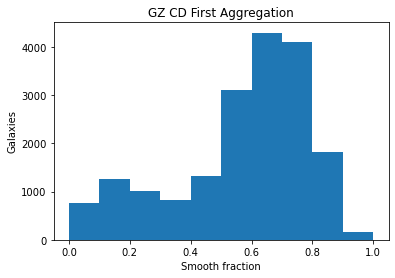

In [29]:
plt.hist(aggregated['smooth-or-featured_smooth_fraction'], bins=10)
plt.xlabel('Smooth fraction')
plt.ylabel('Galaxies')
plt.title('GZ CD First Aggregation')

Text(0.5, 1.0, 'GZ CD First Aggregation')

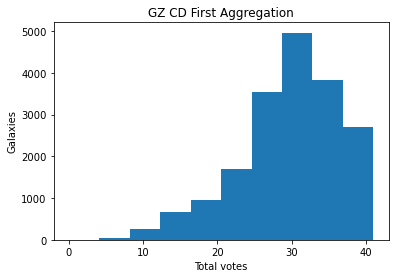

In [34]:
plt.hist(aggregated['smooth-or-featured_total-votes'], bins=10)
plt.xlabel('Total votes')
plt.ylabel('Galaxies')
plt.title('GZ CD First Aggregation')

In [37]:
remaining = -(aggregated['smooth-or-featured_total-votes'] - 40).sum()
remaining

194682.0

In [44]:
# about 25k/week classifications currently
remaining / 25000

7.78728

In [30]:
(aggregated['smooth-or-featured_smooth_fraction'] > 0.5).mean()

0.7040132883244923

In [31]:

aggregated[1:].to_parquet(save_loc, index=False)

In [2]:
import pandas as pd

df = pd.read_parquet(save_loc)

NameError: name 'save_loc' is not defined

In [32]:
# tweak catalog to include renamed columns in format {question}-cd_{answer} expected by zoobot ortho schema

from zoobot.shared.schemas import cosmic_dawn_ortho_schema

df = pd.read_parquet(save_loc)

renamer = {}
for question in cosmic_dawn_ortho_schema.questions:
  renamer[question.text.replace('-cd', '') + '_total-votes'] = question.text + '_total-votes'
  for answer in question.answers:
    renamer[answer.text.replace('-cd', '')] = answer.text
    renamer[answer.text.replace('-cd', '') + '_fraction'] = answer.text + '_fraction'
# print(renamer)
df = df.rename(columns=renamer)

for label_col in cosmic_dawn_ortho_schema.label_cols:
  assert label_col in df.columns.values, 'Missing {}'.format(label_col)

df.to_parquet(save_loc.replace('.parquet', '_ortho.parquet'), index=False)
